# 03_tml_pca

We will stack PCA onto the 02 series notebooks to try and reduce the dimensions of our data. We think that not all features are important

In [1]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [3]:
# load data
train = pd.read_csv(root_dir/"data/train.csv")
test = pd.read_csv(root_dir/"data/test.csv")
print("data loaded")

data loaded


In [4]:
# check shape
print(train.shape)
print(test.shape)

(280145, 138)
(120504, 138)


In [5]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


In [6]:
# scaling data to make it easier for models to train
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

# test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
x_test = scaler.transform(x_test)

# Helper functions

In [7]:
# constants
SEED = 42

In [8]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [9]:
def model_scores(model, test=test, x_test=x_test, y_test=y_test):
  y_pred = model.predict(x_test) 

  print("Utility score: ", utility_score(test, y_pred))
  print("Accuracy: ", accuracy_score(y_test, y_pred))
  
  print("Confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  plt.show()  

  print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

# PCA
The idea behind PCA is to take the original features and compress them into a smaller set of features, while still keeping as much information as possible. As such, if we are compressing into k features, the 1st feature will retain as much % of the variance represented by the data and so on.

The end result is k features, but of note is that the new features have no logical meaning anymore since they are representations of a few features. This is fine as our features are anonymous to begin with - but an important point is that now we have to change our original data to fit the new transformed feature space.

In [10]:
# import model
from sklearn.linear_model import LogisticRegression

# settings to vary
solvers = ['liblinear', 'sag', 'saga', 'lbfgs']
iterations = [100, 1000, 10000]

In [11]:
# import model
from sklearn import decomposition

# settings to vary
n_components = [70, 90, 110, 130]



Logistic Regression model: solver = liblinear, iteration = 100, n_components = 70
Utility score:  333.1931811536784
Accuracy:  0.5188790413596229
Confusion matrix


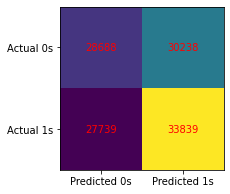

AUC_ROC


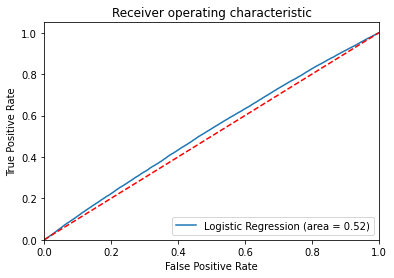



Logistic Regression model: solver = liblinear, iteration = 100, n_components = 90
Utility score:  427.17957547909634
Accuracy:  0.5193437562238598
Confusion matrix


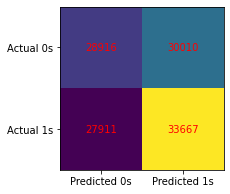

AUC_ROC


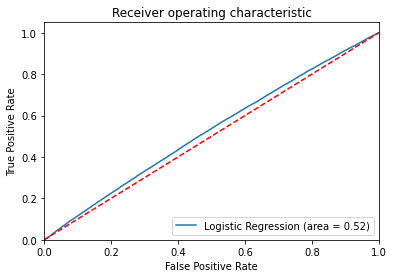



Logistic Regression model: solver = liblinear, iteration = 100, n_components = 110
Utility score:  363.60632664361606
Accuracy:  0.5197005908517559
Confusion matrix


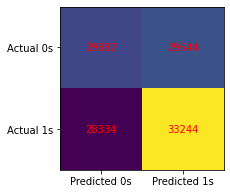

AUC_ROC


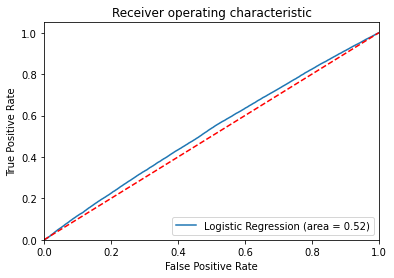



Logistic Regression model: solver = liblinear, iteration = 100, n_components = 130
Utility score:  303.1852533615036
Accuracy:  0.5201819026754299
Confusion matrix


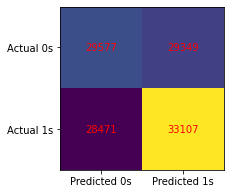

AUC_ROC


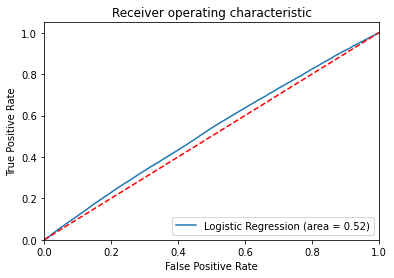



Logistic Regression model: solver = liblinear, iteration = 1000, n_components = 70
Utility score:  312.5212251448683
Accuracy:  0.5185636991303193
Confusion matrix


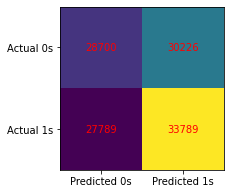

AUC_ROC


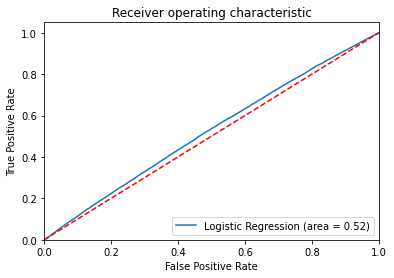



Logistic Regression model: solver = liblinear, iteration = 1000, n_components = 90
Utility score:  397.78941470133066
Accuracy:  0.5191943835889266
Confusion matrix


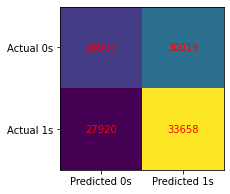

AUC_ROC


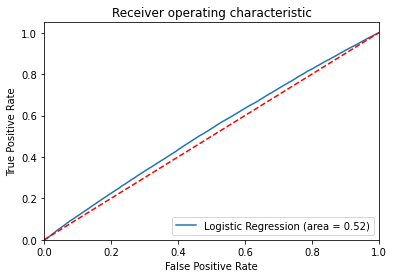



Logistic Regression model: solver = liblinear, iteration = 1000, n_components = 110
Utility score:  363.60632664361606
Accuracy:  0.5197005908517559
Confusion matrix


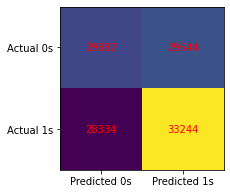

AUC_ROC


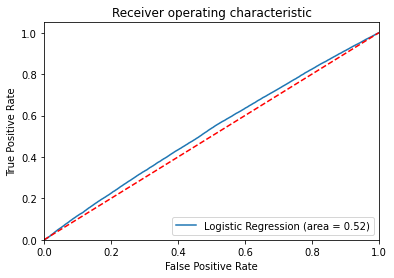



Logistic Regression model: solver = liblinear, iteration = 1000, n_components = 130
Utility score:  303.1852533615036
Accuracy:  0.5201819026754299
Confusion matrix


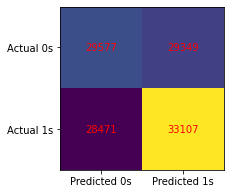

AUC_ROC


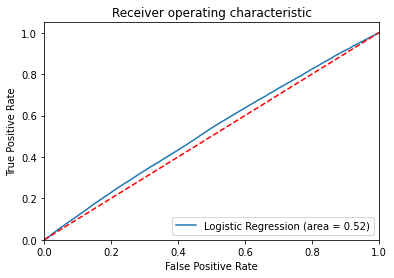



Logistic Regression model: solver = liblinear, iteration = 10000, n_components = 70
Utility score:  328.0877522605326
Accuracy:  0.5184807143331341
Confusion matrix


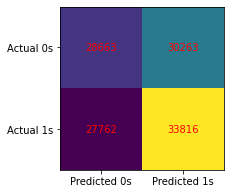

AUC_ROC


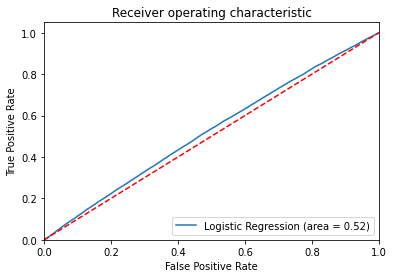



Logistic Regression model: solver = liblinear, iteration = 10000, n_components = 90
Utility score:  393.63087492620355
Accuracy:  0.5194018455818894
Confusion matrix


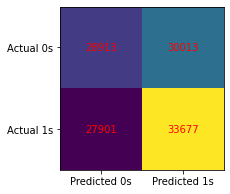

AUC_ROC


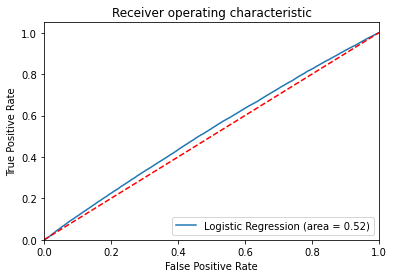



Logistic Regression model: solver = liblinear, iteration = 10000, n_components = 110
Utility score:  363.60632664361606
Accuracy:  0.5197005908517559
Confusion matrix


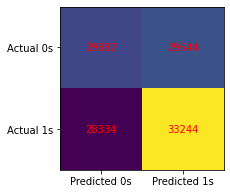

AUC_ROC


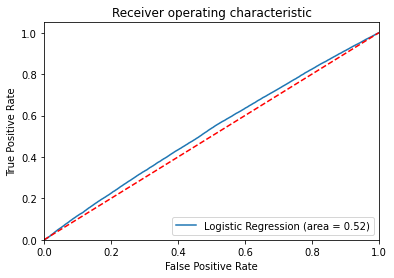



Logistic Regression model: solver = liblinear, iteration = 10000, n_components = 130
Utility score:  303.1852533615036
Accuracy:  0.5201819026754299
Confusion matrix


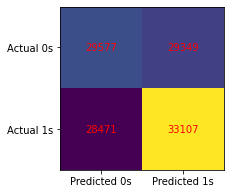

AUC_ROC


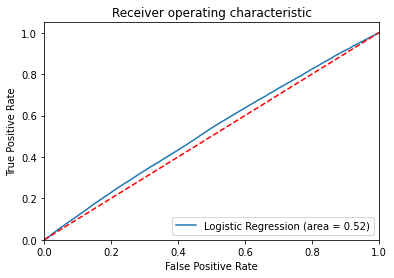



Logistic Regression model: solver = sag, iteration = 100, n_components = 70
Utility score:  327.20703344016357
Accuracy:  0.5186466839275045
Confusion matrix


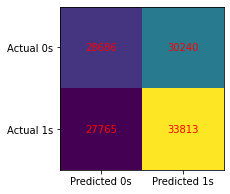

AUC_ROC


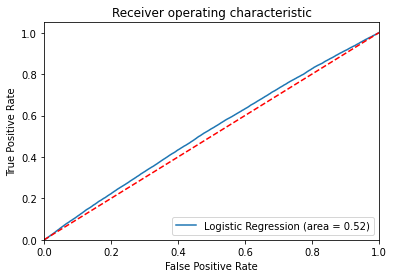



Logistic Regression model: solver = sag, iteration = 100, n_components = 90
Utility score:  399.2172659848806
Accuracy:  0.5192939653455487
Confusion matrix


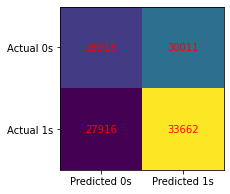

AUC_ROC


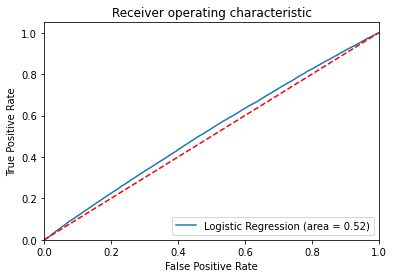



Logistic Regression model: solver = sag, iteration = 100, n_components = 110


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Utility score:  364.4673541504086
Accuracy:  0.5196756954126004
Confusion matrix


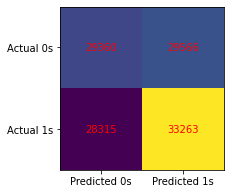

AUC_ROC


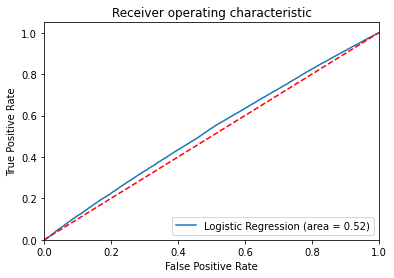



Logistic Regression model: solver = sag, iteration = 100, n_components = 130


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Utility score:  361.91394083852225
Accuracy:  0.520488946425015
Confusion matrix


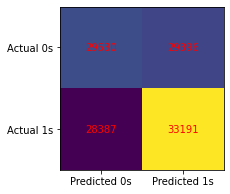

AUC_ROC


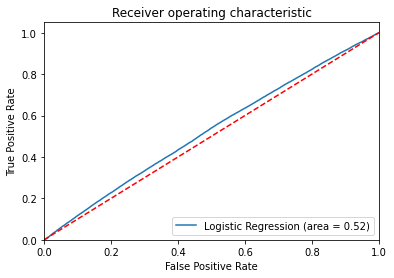



Logistic Regression model: solver = sag, iteration = 1000, n_components = 70
Utility score:  330.61474317663493
Accuracy:  0.5186051915289119
Confusion matrix


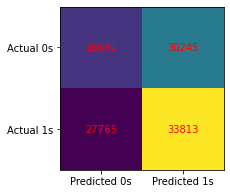

AUC_ROC


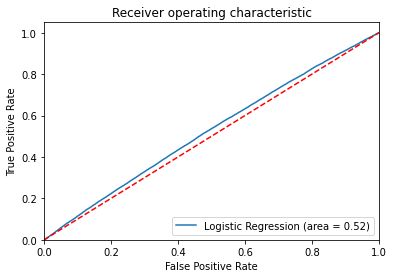



Logistic Regression model: solver = sag, iteration = 1000, n_components = 90
Utility score:  394.1379113022891
Accuracy:  0.5193437562238598
Confusion matrix


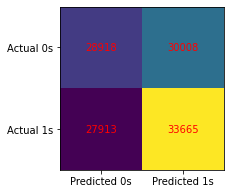

AUC_ROC


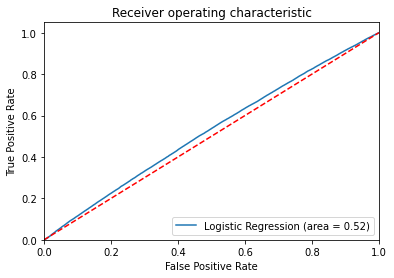



Logistic Regression model: solver = sag, iteration = 1000, n_components = 110
Utility score:  359.4683958040592
Accuracy:  0.5196922923720374
Confusion matrix


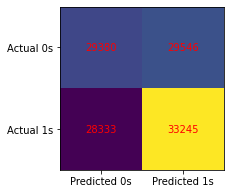

AUC_ROC


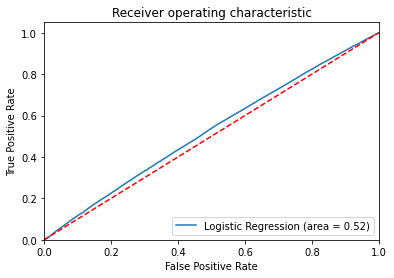



Logistic Regression model: solver = sag, iteration = 1000, n_components = 130


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Utility score:  295.85207709661904
Accuracy:  0.5201736041957113
Confusion matrix


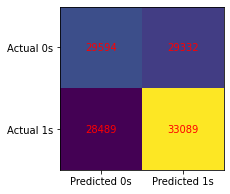

AUC_ROC


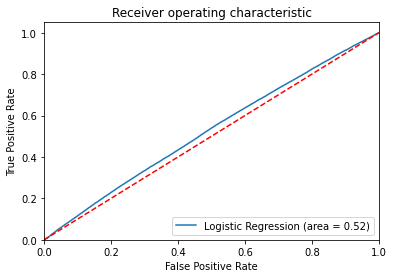



Logistic Regression model: solver = sag, iteration = 10000, n_components = 70
Utility score:  317.3420894617926
Accuracy:  0.5185554006506008
Confusion matrix


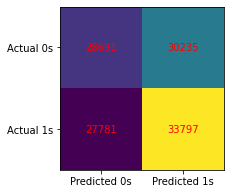

AUC_ROC


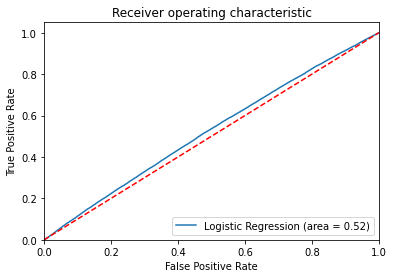



Logistic Regression model: solver = sag, iteration = 10000, n_components = 90
Utility score:  393.28853633277674
Accuracy:  0.5195595166965412
Confusion matrix


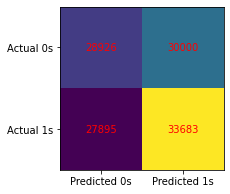

AUC_ROC


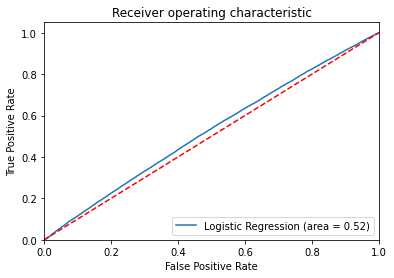



Logistic Regression model: solver = sag, iteration = 10000, n_components = 110
Utility score:  359.4683958040592
Accuracy:  0.5196922923720374
Confusion matrix


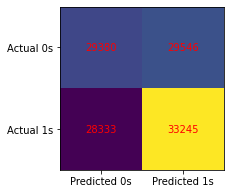

AUC_ROC


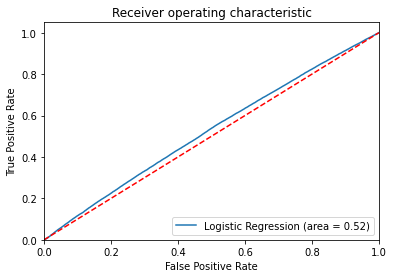



Logistic Regression model: solver = sag, iteration = 10000, n_components = 130
Utility score:  293.87575113166906
Accuracy:  0.5201238133174002
Confusion matrix


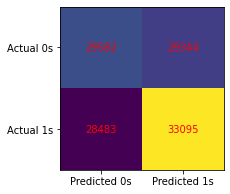

AUC_ROC


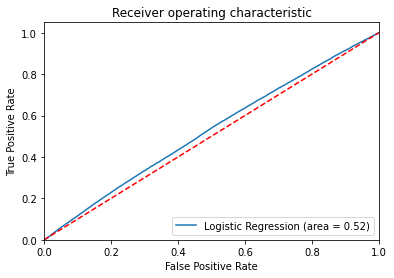



Logistic Regression model: solver = saga, iteration = 100, n_components = 70
Utility score:  310.1876778130913
Accuracy:  0.5185471021708823
Confusion matrix


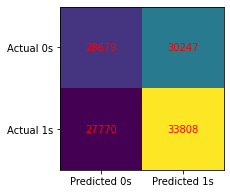

AUC_ROC


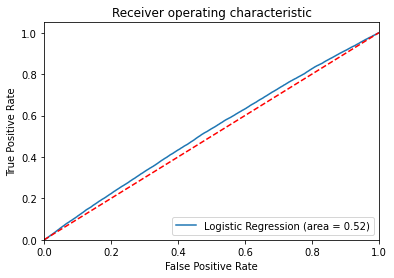



Logistic Regression model: solver = saga, iteration = 100, n_components = 90


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Utility score:  424.33825083672326
Accuracy:  0.5193769501427339
Confusion matrix


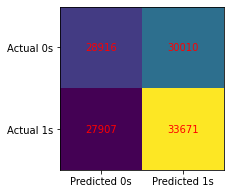

AUC_ROC


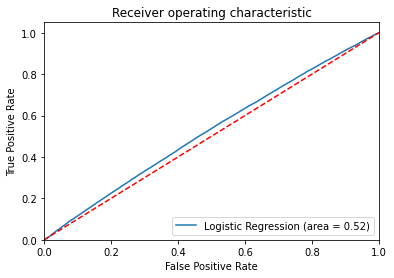



Logistic Regression model: solver = saga, iteration = 100, n_components = 110


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Utility score:  348.60485181426947
Accuracy:  0.5198333665272522
Confusion matrix


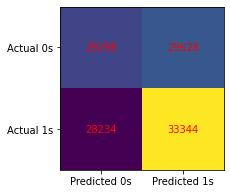

AUC_ROC


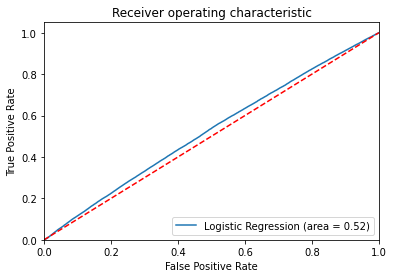



Logistic Regression model: solver = saga, iteration = 100, n_components = 130


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Utility score:  362.83478021912885
Accuracy:  0.5202150965943039
Confusion matrix


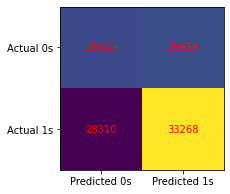

AUC_ROC


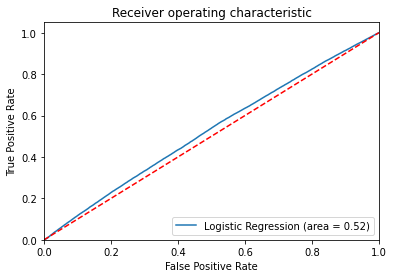



Logistic Regression model: solver = saga, iteration = 1000, n_components = 70
Utility score:  321.49071331920123
Accuracy:  0.5186134900086304
Confusion matrix


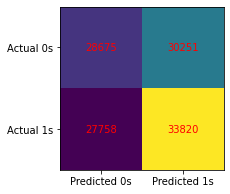

AUC_ROC


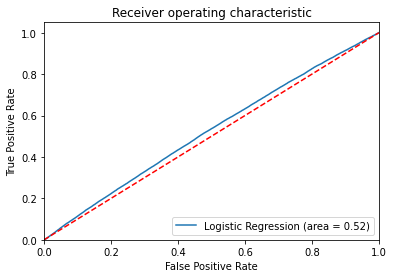



Logistic Regression model: solver = saga, iteration = 1000, n_components = 90
Utility score:  393.7441447580751
Accuracy:  0.5193105623049857
Confusion matrix


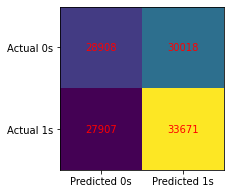

AUC_ROC


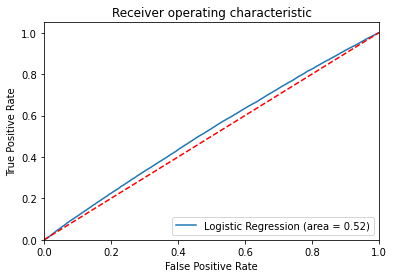



Logistic Regression model: solver = saga, iteration = 1000, n_components = 110
Utility score:  358.3193865893175
Accuracy:  0.5196673969328819
Confusion matrix


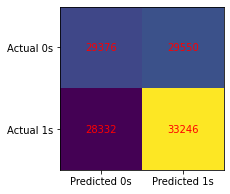

AUC_ROC


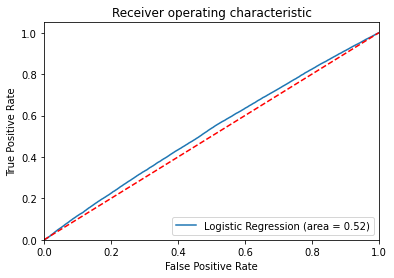



Logistic Regression model: solver = saga, iteration = 1000, n_components = 130


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Utility score:  289.44700724713994
Accuracy:  0.5200989178782447
Confusion matrix


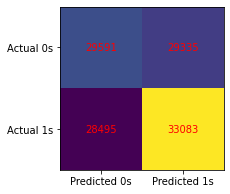

AUC_ROC


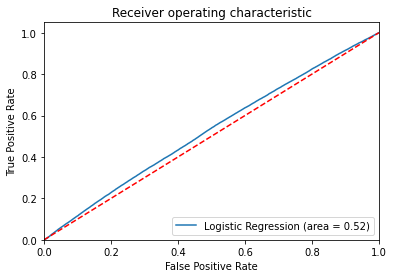



Logistic Regression model: solver = saga, iteration = 10000, n_components = 70
Utility score:  318.84997566599066
Accuracy:  0.5186632808869415
Confusion matrix


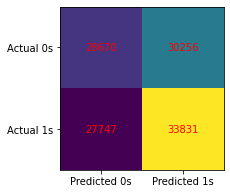

AUC_ROC


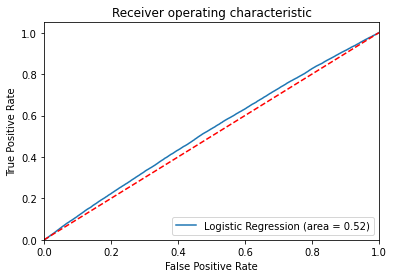



Logistic Regression model: solver = saga, iteration = 10000, n_components = 90
Utility score:  398.96639947207893
Accuracy:  0.5192939653455487
Confusion matrix


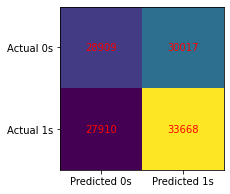

AUC_ROC


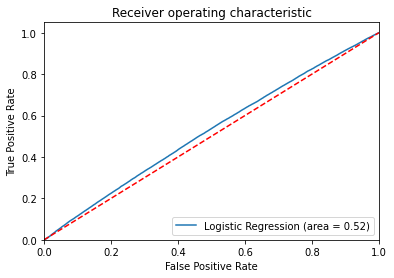



Logistic Regression model: solver = saga, iteration = 10000, n_components = 110
Utility score:  358.3193865893175
Accuracy:  0.5196673969328819
Confusion matrix


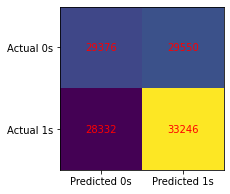

AUC_ROC


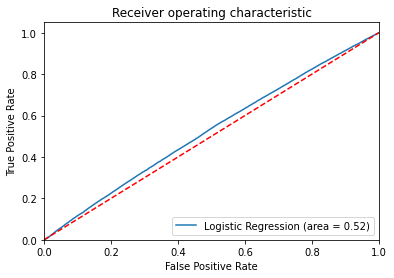



Logistic Regression model: solver = saga, iteration = 10000, n_components = 130
Utility score:  293.3981606851736
Accuracy:  0.5200989178782447
Confusion matrix


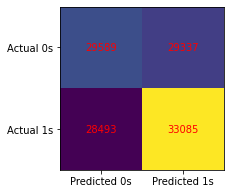

AUC_ROC


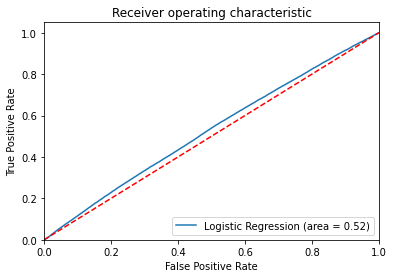



Logistic Regression model: solver = lbfgs, iteration = 100, n_components = 70
Utility score:  317.37051517638895
Accuracy:  0.5185719976100378
Confusion matrix


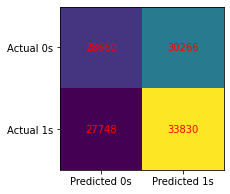

AUC_ROC


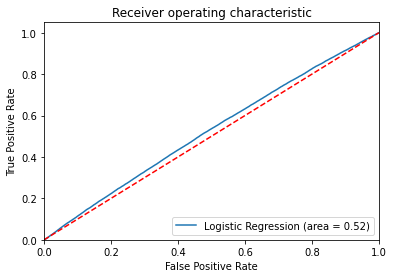



Logistic Regression model: solver = lbfgs, iteration = 100, n_components = 90
Utility score:  394.71633330337494
Accuracy:  0.5192275775078006
Confusion matrix


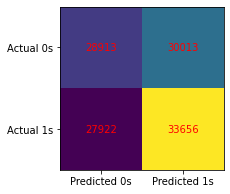

AUC_ROC


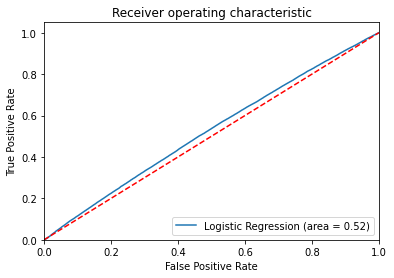



Logistic Regression model: solver = lbfgs, iteration = 100, n_components = 110


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Utility score:  373.11511622627194
Accuracy:  0.5198665604461262
Confusion matrix


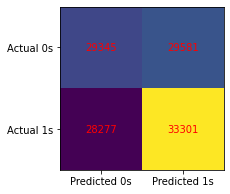

AUC_ROC


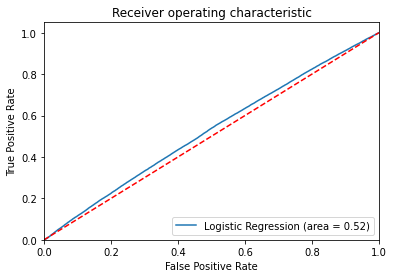



Logistic Regression model: solver = lbfgs, iteration = 100, n_components = 130


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Utility score:  311.9997731290663
Accuracy:  0.5198831574055633
Confusion matrix


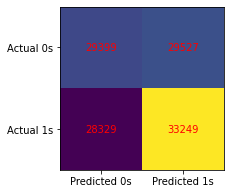

AUC_ROC


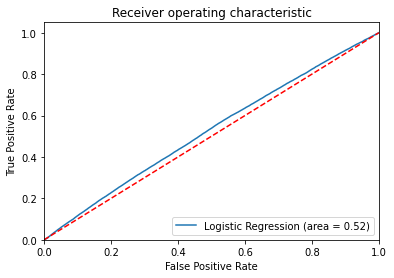



Logistic Regression model: solver = lbfgs, iteration = 1000, n_components = 70
Utility score:  322.87175789506426
Accuracy:  0.5185056097722898
Confusion matrix


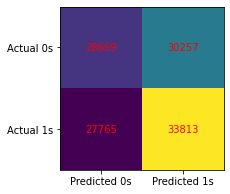

AUC_ROC


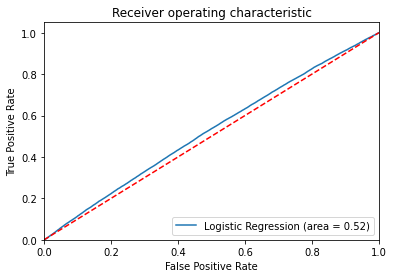



Logistic Regression model: solver = lbfgs, iteration = 1000, n_components = 90
Utility score:  418.99331995689795
Accuracy:  0.5192358759875191
Confusion matrix


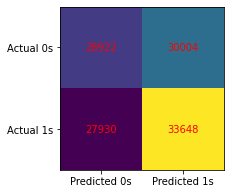

AUC_ROC


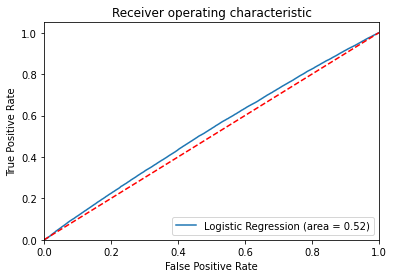



Logistic Regression model: solver = lbfgs, iteration = 1000, n_components = 110
Utility score:  353.70770913953237
Accuracy:  0.5197254862909115
Confusion matrix


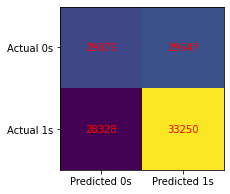

AUC_ROC


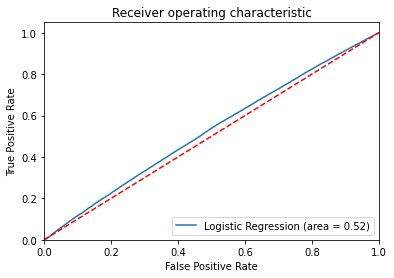



Logistic Regression model: solver = lbfgs, iteration = 1000, n_components = 130
Utility score:  283.35681108976144
Accuracy:  0.5199578437230299
Confusion matrix


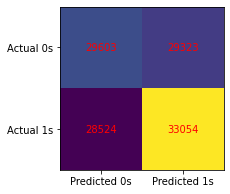

AUC_ROC


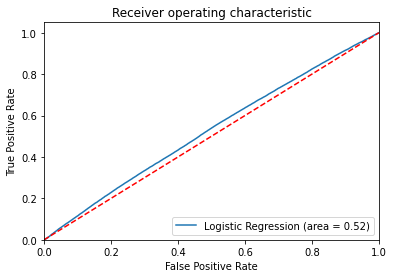



Logistic Regression model: solver = lbfgs, iteration = 10000, n_components = 70
Utility score:  308.3031954549348
Accuracy:  0.518638385447786
Confusion matrix


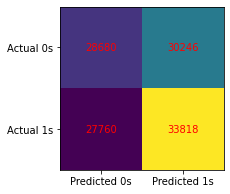

AUC_ROC


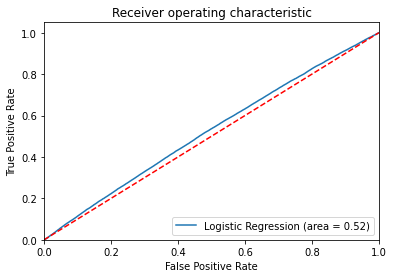



Logistic Regression model: solver = lbfgs, iteration = 10000, n_components = 90
Utility score:  384.60969458547675
Accuracy:  0.5195097258182301
Confusion matrix


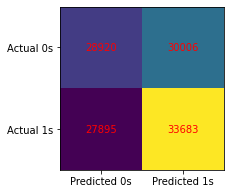

AUC_ROC


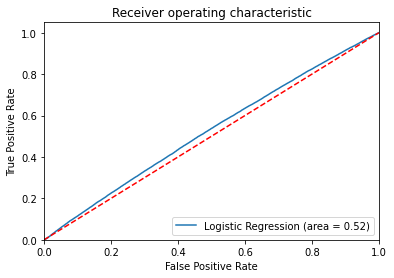



Logistic Regression model: solver = lbfgs, iteration = 10000, n_components = 110
Utility score:  353.70770913953237
Accuracy:  0.5197254862909115
Confusion matrix


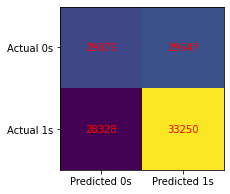

AUC_ROC


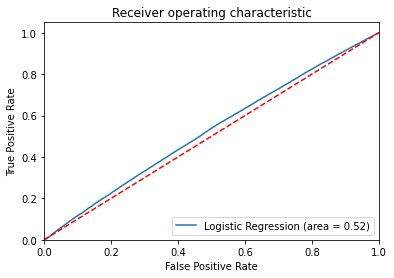



Logistic Regression model: solver = lbfgs, iteration = 10000, n_components = 130
Utility score:  283.35681108976144
Accuracy:  0.5199578437230299
Confusion matrix


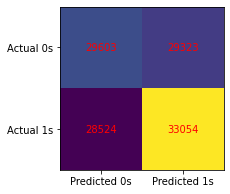

AUC_ROC


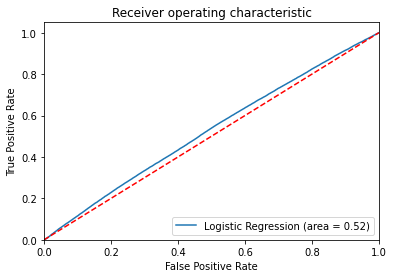

In [12]:
# iterate over settings for the model
for solver in solvers:
  for iteration in iterations:
    for n_component in n_components:
      pca = decomposition.PCA(n_components=n_component)
      pca.fit(x_train)
      x_train_pca = pca.transform(x_train)
      x_test_pca = pca.transform(x_test)

      print(f"\n\nLogistic Regression model: solver = {solver}, iteration = {iteration}, n_components = {n_component}")    

      model = LogisticRegression(solver=solver, max_iter=iteration)
      model.fit(x_train_pca, y_train)
      model_scores(model, x_test=x_test_pca)

# Conclusion

* Utility score: 
* Accuracy: 